# Exercise 71. 

![img](imgs/7.1.1.png)
![img](imgs/7.1.2.png)
![img](imgs/7.1.3.png)


In [1]:
!pip install keras
!pip install numpy
!pip install tensorflow
!pip install matplotlib
!pip install gym

    100% |████████████████████████████████| 348kB 2.0MB/s ta 0:00:01
    100% |████████████████████████████████| 256kB 2.7MB/s ta 0:00:01
    100% |████████████████████████████████| 4.8MB 254kB/s ta 0:00:011
  Using cached https://files.pythonhosted.org/packages/67/4b/141a581104b1f6397bfa78ac9d43d8ad29a7ca43ea90a2d863fe3056e86a/six-1.11.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 12.1MB 103kB/s ta 0:00:011
    100% |████████████████████████████████| 30.8MB 39kB/s eta 0:00:011
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /home/daniel/.cache/pip/wheels/03/05/65/bdc14f2c6e09e82ae3e0f13d021e1b6b2481437ea2f207df3f
Successfully built pyyaml
  Using cached https://files.pythonhosted.org/packages/c0/e7/08f059a00367fd613e4f2875a16c70b6237268a1d6d166c6d36acada8301/numpy-1.14.3-cp27-cp27mu-manylinux1_x86_64.whl
    100% |████████████████████████████████| 49.1MB 26kB/s  eta 0:00:01
    100% |████████████████████████████████| 8.9MB 141kB/s ta 0:00

  Running setup.py bdist_wheel for termcolor ... done
  Stored in directory: /home/daniel/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Running setup.py bdist_wheel for html5lib ... done
  Stored in directory: /home/daniel/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built gast absl-py termcolor html5lib
    100% |████████████████████████████████| 12.6MB 102kB/s ta 0:00:011
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c0/e7/08f059a00367fd613e4f2875a16c70b6237268a1d6d166c6d36acada8301/numpy-1.14.3-cp27-cp27mu-manylinux1_x86_64.whl
    100% |████████████████████████████████| 102kB 5.6MB/s ta 0:00:01
    100% |████████████████████████████████| 952kB 1.1MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/dc/83/15f7833b70d3e067c

In [2]:
# Code adapted from https://github.com/rlcode/reinforcement-learning/tree/master/2-cartpole
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/daniel/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Define the agent that is going to be used for training
class DoubleDQNAgent:
    def __init__(self, state_size, action_size):
        # Define state and action space sizes
        self.state_size = state_size
        self.action_size = action_size
        # Hyper-parameters for the Double-DQN architecture
        self.discount_factor = 0.99 # Discount factor for Bellman equation
        self.learning_rate = 0.001 # Learning rate for ADAM optimizer
        self.epsilon = 1.0 # Initial epsilon value (for epsilon greedy policy)
        self.epsilon_decay = 0.999 # Epsilon decay (for epsilon greedy policy)
        self.epsilon_min = 0.01 # Minimal epsilon value (for epsilon greedy policy)
        self.batch_size = 64 # Batch size for replay
        self.train_start = 1000 # Adds a delay, for the memory to have data before starting the training
        # Create a replay memory using deque
        self.memory = deque(maxlen=2000)
        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model() # The target model is a NN used to increase stability
        # Initialize target model
        self.update_target_model()

    # NN input is the state, output is the estimated Q value for each action
    def build_model(self):
        # We build a model with 3 layers
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu',kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu',kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',kernel_initializer='he_uniform'))
        #model.summary() # Uncomment to see the model summary provided by Keras
        # Compile the model: use Mean Squared Error as loss function, ADAM as optimizer
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # Function to update the target model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # Epsilon greedy policy 
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # Save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train_model(self):
        if len(self.memory) < self.train_start:
            return # Start training only when there are some samples in the memory
        # Pick samples randomly from replay memory (with batch_size)
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)
        # Preprocess the batch by storing the data in different vectors
        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])
        # Obtain the targets for the NN training phase
        target = self.model.predict(update_input)
        target_next = self.model.predict(update_target)
        target_val = self.target_model.predict(update_target) # Use the target network HERE for further stability

        for i in range(self.batch_size):
            # Get maximum Q value at s' from target model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                a = np.argmax(target_next[i])
                target[i][action[i]] = reward[i] + self.discount_factor * (target_val[i][a])
        # Fit the model!
        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

[2018-05-24 15:49:22,203] Making new env: CartPole-v1


episode: 0   score: 12.0   memory length: 13   epsilon: 0.9870777147137147
episode: 1   score: 28.0   memory length: 42   epsilon: 0.9588496310845509
episode: 2   score: 34.0   memory length: 77   epsilon: 0.925854183751895
episode: 3   score: 78.0   memory length: 156   epsilon: 0.8554924148377159
episode: 4   score: 14.0   memory length: 171   epsilon: 0.8427494672348417
episode: 5   score: 14.0   memory length: 186   epsilon: 0.8301963316171974
episode: 6   score: 58.0   memory length: 245   epsilon: 0.7826085988474126
episode: 7   score: 28.0   memory length: 274   epsilon: 0.7602278474153183
episode: 8   score: 27.0   memory length: 302   epsilon: 0.7392263587988196
episode: 9   score: 53.0   memory length: 356   epsilon: 0.7003478640347469
episode: 10   score: 113.0   memory length: 470   epsilon: 0.6248553120386914
episode: 11   score: 54.0   memory length: 525   epsilon: 0.5913999978901242
episode: 12   score: 75.0   memory length: 601   epsilon: 0.548098260578011
episode: 13  

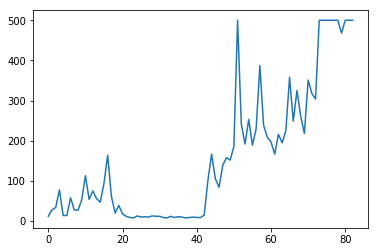

In [4]:
# Load Cart Pole from gym
env = gym.make('CartPole-v1')
# IMPORTANT NOTE: The CartPole environment allows up to 500 time steps. That is the maximum time of play 
# This time could be increased with env._max_episode_steps, but we use 500 for demostrating
# Get size of state and action
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
# Create the agent
agent = DoubleDQNAgent(state_size, action_size)
EPISODES = 300 # Max number of episodes: it usually takes 100-200 to train successfully (2 ~ 5 min approx)
scores, episodes = [], [] # To store values for plotting
break_flag=False # To stop training when the agent has successfully learned
for e in range(EPISODES):
    if break_flag:
        break
    done = False
    score = 0
    state = env.reset() # Set the initial state
    state = np.reshape(state, [1, state_size])

    while not done: # Iterate while the game has not finished
        # Get action for the current state and go one step in environment
        action = agent.get_action(state) # Using epsilon-greedy policy
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        # If an action makes the episode end before time (i.e, before 499 time steps), then give a penalty of -100
        reward = reward if not done or score == 499 else -100

        # Save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, done)
        # Train
        agent.train_model()
        score += reward
        state = next_state
        if done:
            # Update target model after each episode
            agent.update_target_model()
            # Store values for plotting
            score = score if score == 500 else score + 100
            scores.append(score)
            episodes.append(e)
            # Output the results of the episode
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)

            # Stop if mean scores of last 10 episodes is higher than 490 
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                break_flag=True
# Output whether the agent learnt or not
if break_flag:
    print("Training finished successfully")
else:
    print("Training finished unsuccessfully")
# Plot the scores vs the episodes
plt.plot(episodes, scores)
plt.show()

In [0]:
# Run the game once with the trained network and store the values of the position and angle of the cartpole
print("Obtaining data from trained network")
pos_vector=[]
angle_vector=[]
state = env.reset()
state = np.reshape(state, [1, state_size])
done=False
while not done:
    pos_vector.append(state[0,0])
    angle_vector.append(state[0,2])
    action = agent.get_action(state)
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    state = next_state
    if done:
        break
T=len(pos_vector)
print("Data obtained")
# Animate the data: to observe what our network has learned
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, patches
from IPython.display import HTML
print("Creating animation")
fig = plt.figure()
ax = plt.axes(xlim=(-4, 4), ylim=(-1, 3), aspect=1)
ax.set_xticks([])
ax.set_yticks([])

mag1 = plt.Rectangle((0,0), width= 1, height= 0.5, angle=0, fc='black', alpha=0)
line1, = ax.plot([], [], 'b', zorder=1,linewidth=3.0)
line2, = ax.plot([], [], 'r', zorder=1,linewidth=2.0)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    ax.add_patch(mag1)
    return mag1, line1, line2,

def animate(i):
    mag1.set_alpha(1)
    mag1.xy = (pos_vector[i],0)
    x0=pos_vector[i]+0.5
    y0=0.5
    x1=x0+np.cos(np.pi/2-angle_vector[i])
    y1=y0+np.sin(np.pi/2-angle_vector[i])
    line1.set_data([x0, x1], [y0, y1])
    line2.set_data([-2.4, 2.4], [0,0])
    return mag1, line1, line2, 

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=T, 
                               interval=25, blit=True)

HTML(anim.to_jshtml())